In [1]:
import pandas as pd
import numpy as np
import sklearn
import xmltodict

In [2]:
import urllib2
import datetime

In [3]:
def read_data(filenames):
    arrays = [0,0,0]
    for i in xrange(len(filenames)):
        arrays[i] = pd.read_csv(filenames[i])
    return arrays

In [4]:
def yes_1(x):
    return x.replace('yes', 1).replace('no',-1).replace("excellent",2).replace("good",1).replace(
        "satisfactory",0).replace("poor",-1).replace("no data",0).replace("Investment", 1).replace("OwnerOccupier",-1)

In [5]:
def my_impute(data):
    data["life_sq"]=data["life_sq"]/data["full_sq"]
    data["max_floor"]=data["max_floor"]/data["floor"]
    data["num_room"]=data["num_room"]/data["full_sq"]
    data['green_part_2000']=data['green_part_2000'].fillna(data['green_part_1500'])
    data['prom_part_5000']=data['prom_part_5000'].fillna(data['prom_part_2000'])
    data=data.apply(yes_1)
    medImputer=Imputer(strategy='median')
    mfImputer=Imputer(strategy='most_frequent')
    data[["material","build_year","state","product_type"]]=mfImputer.fit_transform(data[["material","build_year","state","product_type"]])
    data[["life_sq","max_floor","num_room","kitch_sq"]]=medImputer.fit_transform(data[["life_sq","max_floor","num_room","kitch_sq"]])
    data["build_year"]=2017-data["build_year"]
    return data   

In [6]:
def my_transport(data):
    data["metro_km_walk"]=data["metro_km_walk"].fillna(data["metro_km_avto"])
    data["metro_min_walk"]=data["metro_min_walk"].fillna(data["metro_km_avto"]*12)
    data["railroad_station_walk_km"]=data["railroad_station_walk_km"].fillna(data["railroad_station_avto_km"])
    data["railroad_station_walk_min"]=data["railroad_station_walk_min"].fillna(data["railroad_station_avto_km"]*12)
    data["ID_railroad_station_walk"]=data["ID_railroad_station_walk"].fillna(data["ID_railroad_station_avto"])
    return data

In [7]:
def my_cafe(data):
    st0=['cafe_sum_5000_min_price_avg','cafe_sum_5000_max_price_avg','cafe_avg_price_5000']
    l=['5000','3000','2000','1500','1000','500']
    medImputer=Imputer(strategy='median')
    data[st0]=medImputer.fit_transform(data[st0])
    for i in xrange(len(l)-1):
        st1=[st.replace('5000',str(l[i+1])) for st in st0]
        st2=[st.replace('5000',str(l[i])) for st in st0]
        for k in xrange(len(st1)):
            data[st1[k]]=data[st1[k]].fillna(data[st2[k]])
    return data        

In [8]:
def rm_col(data, thrs):
    k=len(data)-data.count()
    return list(k[k<thrs].index)    

In [9]:
from sklearn.preprocessing import Imputer
def data_transform(data, macro, div):
    data["timestamp"]=pd.to_datetime(data["timestamp"],format='%Y-%m-%d')
    macro["timestamp"]=pd.to_datetime(macro["timestamp"],format='%Y-%m-%d')
    data = data.merge(macro, left_on='timestamp', right_on='timestamp', how='left')   
    data=my_impute(data)
    data=data.ix[data['floor']>0]
    data=data.ix[data['full_sq']>0]
    data=my_transport(data)
    data=my_cafe(data)
    data1 = data[data[div[0]].isin(div[1])]
    data2 = data[-data[div[0]].isin(div[1])]
    data1=data1[rm_col(data1,650)]
    data2=data2[rm_col(data2,1800)]
    return data1, data2    

In [10]:
def printna(data):
    k=len(data)-data.count()
    print k[k>0]

In [11]:
def er10(data):
    err = (data.full_sq>data.life_sq*10)&(data.life_sq>2)
    data.ix[err,'full_sq'] = data.ix[err,'full_sq']/10
    return data

In [12]:
def excl_cheat(data, quan = .05):
    data = data[data["price_doc"]>2000000]
    df = data.groupby("sub_area")
    result = pd.DataFrame()
    for name, group in df:
        q = group.pr_RUB_SQM.quantile(quan)
        group = group[group.pr_RUB_SQM > q]
        result = result.append(group)
    return result

In [13]:
filenames = ["./data/macro.csv","./data/train.csv/train.csv","./data/test.csv/test.csv"]
[macro, data, data_test] = read_data(filenames)
data=er10(er10(data))
data["pr_RUB_SQM"] = data["price_doc"]/data["full_sq"]
#data = excl_cheat(data)

In [14]:
data_test["full_sq"]=data_test["full_sq"].fillna(data_test["life_sq"])
data_test.ix[data_test["full_sq"]==0,'full_sq'] = data_test.ix[data_test["full_sq"]==0,'life_sq']

In [15]:
div=['sub_area',data[data.preschool_quota.isnull()]['sub_area'].value_counts().index.tolist()]
[data1, data2]=data_transform(data, macro, div)
[data_test1, data_test2]=data_transform(data_test, macro, div)

In [16]:
data_test2=data_test2.fillna(0)

In [17]:
printna(data_test1)
printna(data_test2)

Series([], dtype: int64)
Series([], dtype: int64)


# NN

In [18]:
from sklearn.metrics import r2_score

In [19]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [20]:
def larger_model(dim, reg=0.01):
    # create model
    model = Sequential()
    model.add(Dense(dim, input_dim=dim, kernel_initializer='random_normal', activation='relu', 
                    kernel_regularizer=regularizers.l2(reg),activity_regularizer=regularizers.l1(reg)))
    model.add(Dense(148, kernel_initializer='random_normal', activation='relu',
                   kernel_regularizer=regularizers.l2(reg),activity_regularizer=regularizers.l1(reg)))
    model.add(Dense(20, kernel_initializer='random_normal', activation='relu',
                   kernel_regularizer=regularizers.l2(reg),activity_regularizer=regularizers.l1(reg)))
    model.add(Dense(1, kernel_initializer='random_normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [21]:
#NN1=load_model('nn1.h5')
#NN2=load_model('nn2.h5')

In [22]:
ex=["id","timestamp","sub_area", "ID_metro", "ID_railroad_station_walk", "ID_railroad_station_avto", 
    "ID_big_road1", "ID_big_road2", "ID_railroad_terminal", "ID_bus_terminal", 'hospital_beds_raion']
v1=[x for x in list(data_test1.columns.values) if x not in ex]
v=[x for x in list(data_test2.columns.values) if x not in ex]
Y2, X2, X2_test = map(np.array, [data2["price_doc"], data2[v1], data_test2[v1]])
batch_size2=X2.shape[0]/50 
#x_train, x_test = labels(x_train), labels(x_test||

In [23]:
batch_size2

473

In [24]:
NN2 = larger_model(dim=X2.shape[1], reg=0.01)

In [25]:
NN2.fit(X2,Y2, batch_size=batch_size2, epochs=200, verbose=1)
#NN2.fit(X2,Y2, batch_size=batch_size2, epochs=10, verbose=1)

Epoch 1/200
23692/23692 [==============================] - 0s - loss: 45965199494504.8125     
Epoch 2/200
23692/23692 [==============================] - 0s - loss: 25628902796968.3008     
Epoch 3/200
23692/23692 [==============================] - 0s - loss: 25096957714126.3398     
Epoch 4/200
23692/23692 [==============================] - 0s - loss: 24833650304404.7266     
Epoch 5/200
23692/23692 [==============================] - 0s - loss: 24615977878544.0781     
Epoch 6/200
23692/23692 [==============================] - 0s - loss: 24332367823334.8477     
Epoch 7/200
23692/23692 [==============================] - 0s - loss: 24260114682346.3047     
Epoch 8/200
23692/23692 [==============================] - 0s - loss: 24109604512619.4922     
Epoch 9/200
23692/23692 [==============================] - 0s - loss: 24035936482739.8438     
Epoch 10/200
23692/23692 [==============================] - 0s - loss: 23911559606287.9023     
Epoch 11/200
23692/23692 [=======================

In [27]:
print r2_score(NN2.predict(X2),Y2)

-1.58802778764


In [28]:
#NN2.save('nn2.h5')

In [29]:
Y1, X1, X1_test = map(np.array, [data1["price_doc"], data1[v1], data_test1[v1]])
#x_train, x_test = labels(x_train), labels(x_test||
batch_size1=X1.shape[0]/50 

In [30]:
NN1 = larger_model(dim=X1.shape[1], reg=15000)

In [ ]:
NN1.fit(X1,Y1, batch_size=batch_size1, epochs=200, verbose=0)
NN1.fit(X1,Y1, batch_size=batch_size1, epochs=50, verbose=1)

In [56]:
#NN1.save('nn1.h5')
#NN1=load_model('nn1.h5')

In [57]:
print r2_score(NN1.predict(X1),Y1),r2_score(NN2.predict(X2),Y2)

-3.32262013006e+25 -3.5981464011


In [164]:
[data_test1["price_doc"], data_test2["price_doc"]] = [NN1.predict(X1_test), NN2.predict(X2_test)]
out = data_test1[["id","price_doc"]].append(data_test2[["id","price_doc"]])
out.to_csv("./nn2.csv", index=False)

# Random Forest

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [31]:
def fit_predict(data, data_test, ex, d, rs1=1, rs2=1, ts=0.1, md=5, sl=10, ne=100):
    v=[x for x in list(data_test.columns.values) if x not in ex]
    [values, features, features_test]  = [data[d], data[v], data_test[v]]
    train, test, y_train, y_test = train_test_split(features, values, test_size=ts, random_state=rs1)
    RFreg=RandomForestRegressor(random_state=rs2, max_depth=md, min_samples_leaf=sl, n_estimators=ne, oob_score=True)
    RFreg.fit(train,y_train)
    pred1 = RFreg.predict(test)
    print r2_score(y_test, pred1)
    pred_f=RFreg.predict(features_test)
    return features_test["full_sq"]*pred_f

In [32]:
ex=["id","timestamp","sub_area", "ID_metro", "ID_railroad_station_walk", "ID_railroad_station_avto", 
    "ID_big_road1", "ID_big_road2", "ID_railroad_terminal", "ID_bus_terminal"]

In [33]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
def my_hist(data, d):
    x=data[d].as_matrix()
    bins = np.arange(0,3e5,1e4)
    plt.hist(x, facecolor='green', alpha=0.75, bins=bins)
    plt.show()
    

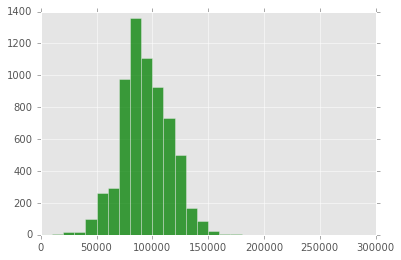

In [34]:
d = "pr_RUB_SQM"
my_hist(data1,d)

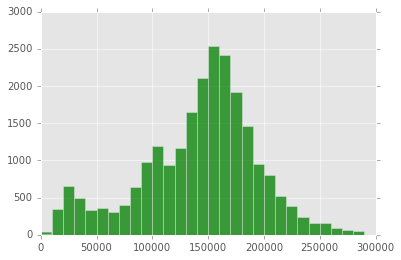

In [35]:
my_hist(data2,d)

In [37]:
[data_test1["price_doc"], data_test2["price_doc"]] = [fit_predict(data1, data_test1, ex, d, rs1=3, sl=5),
                                                      fit_predict(data2, data_test2, ex, d, rs1=5, sl=10)]
out = data_test1[["id","price_doc"]].append(data_test2[["id","price_doc"]])
out.to_csv("./result2.csv", index=False)

0.505425669374
-0.199517942226


In [29]:
class ColumnApplier(object):
    def __init__(self, column_stages):
        self._column_stages = column_stages

    def fit(self, X, y):
        for i, k in self._column_stages.items():
            k.fit(X[:, i])

        return self

    def transform(self, X):
        X = X.copy()
        for i, k in self._column_stages.items():
            X[:, i] = k.transform(X[:, i])

        return X